Import Modules

In [2]:
%load_ext tensorboard

In [1]:
#Final yes

#modules
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend as K
import keras_tuner as kt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from tqdm.notebook import tqdm
import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
import haha

#random seed sehingga seed modelling pada module tensorflow dapat direplikasi
tf.random.set_seed(7)
log_dir = "../../assets/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

Using TensorFlow backend


## Pre modelling

Load dataset

In [2]:
#load dataset
df=pd.read_csv("../../Data/Harian/Rata Harian.csv").iloc[:,2]

#get data from 15 latest months
df=df[-(30*15):]

Rescale data

In [3]:
#Rescale the data to the range of 0-to-1
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df.values.reshape(-1,1))
df=scaler.transform(df.values.reshape(-1,1))

Train Test split

In [4]:
#train test split; train 12 months, 3 months for testing
train=df[:30*12]; test=df[30*12:]

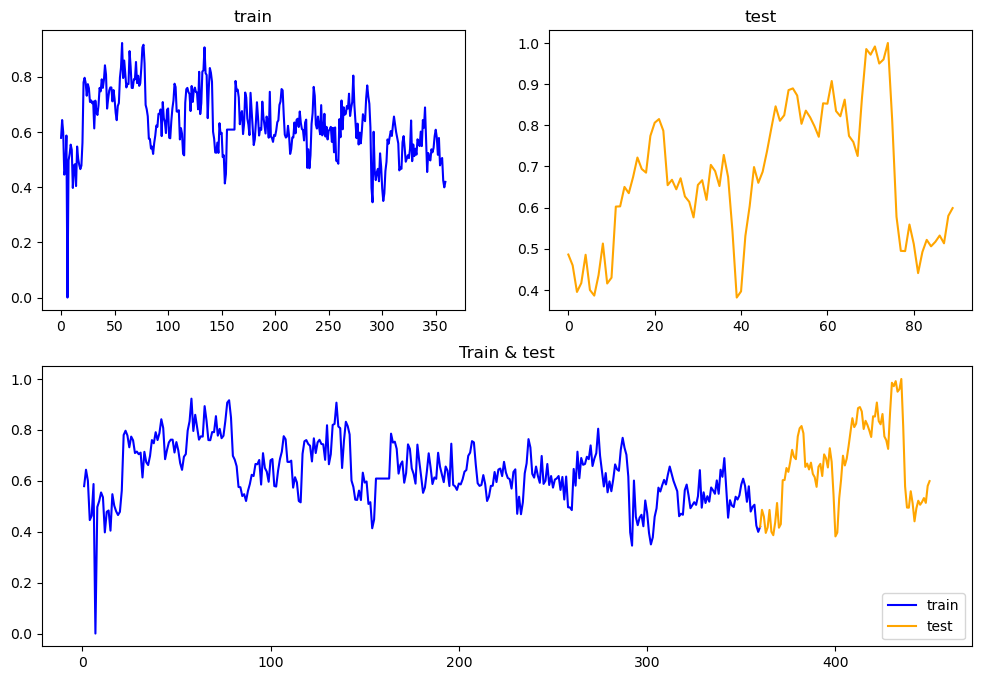

In [5]:
haha.plottraintest(train, test)

lag variable

In [6]:
# reshape into X=t and Y=t+1
t=30
trainX, trainY = haha.lag(train,t)
testX, testY = haha.lag(test,t)

In [7]:
#ubah data sehingga kompatibel dengan shape input model
# reshape input to be [samples, features, time steps]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

## Modelling and fitting

declare necessities 

In [8]:
#metrics
def r2scoremetrics(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - (SS_res/SS_tot) )                              #Doesn't get used due to a misleading val_score during training


#callback
def tensorboardlogger():
    return [keras.callbacks.ModelCheckpoint(log_dir+"/callbacks", save_weights_only=True),
            tf.keras.callbacks.TensorBoard(log_dir)]
    
class SelectiveProgbarLogger(tf.keras.callbacks.ProgbarLogger):
    def __init__(self, verbose, epoch_interval, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.default_verbose = verbose
        self.epoch_interval = epoch_interval
    
    def on_epoch_begin(self, epoch, *args, **kwargs):
        self.verbose = (
            0 
                if epoch % self.epoch_interval != 0 
                else self.default_verbose
        )
        super().on_epoch_begin(epoch, *args, **kwargs)

Model

In [9]:
batch_size=32

#create model
def getmodel_compile():
    model=keras.Sequential([
        
        keras.layers.LSTM(4, input_shape=(t, 1), return_sequences=True),                   #input and 1st layer
        keras.layers.LSTM(8),                                                              #2nd layer
        keras.layers.Dense(1)])                                                                                             #output (pakai 1 karena output berbentuk regresi)
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.MeanAbsolutePercentageError()])
    return model

Fitting

In [ ]:
model=getmodel_compile()

thehistory=model.fit(trainX, trainY, epochs=1000, validation_data=(testX, testY), 
                     batch_size=batch_size, verbose=0, 
                     callbacks=[tensorboardlogger(), SelectiveProgbarLogger(verbose=1, epoch_interval=10)])

In [139]:
model.save("../../assets/testt30.keras")

Check fitting metrics history by plot | Nt: y_true, y_pred haven't been denormalized

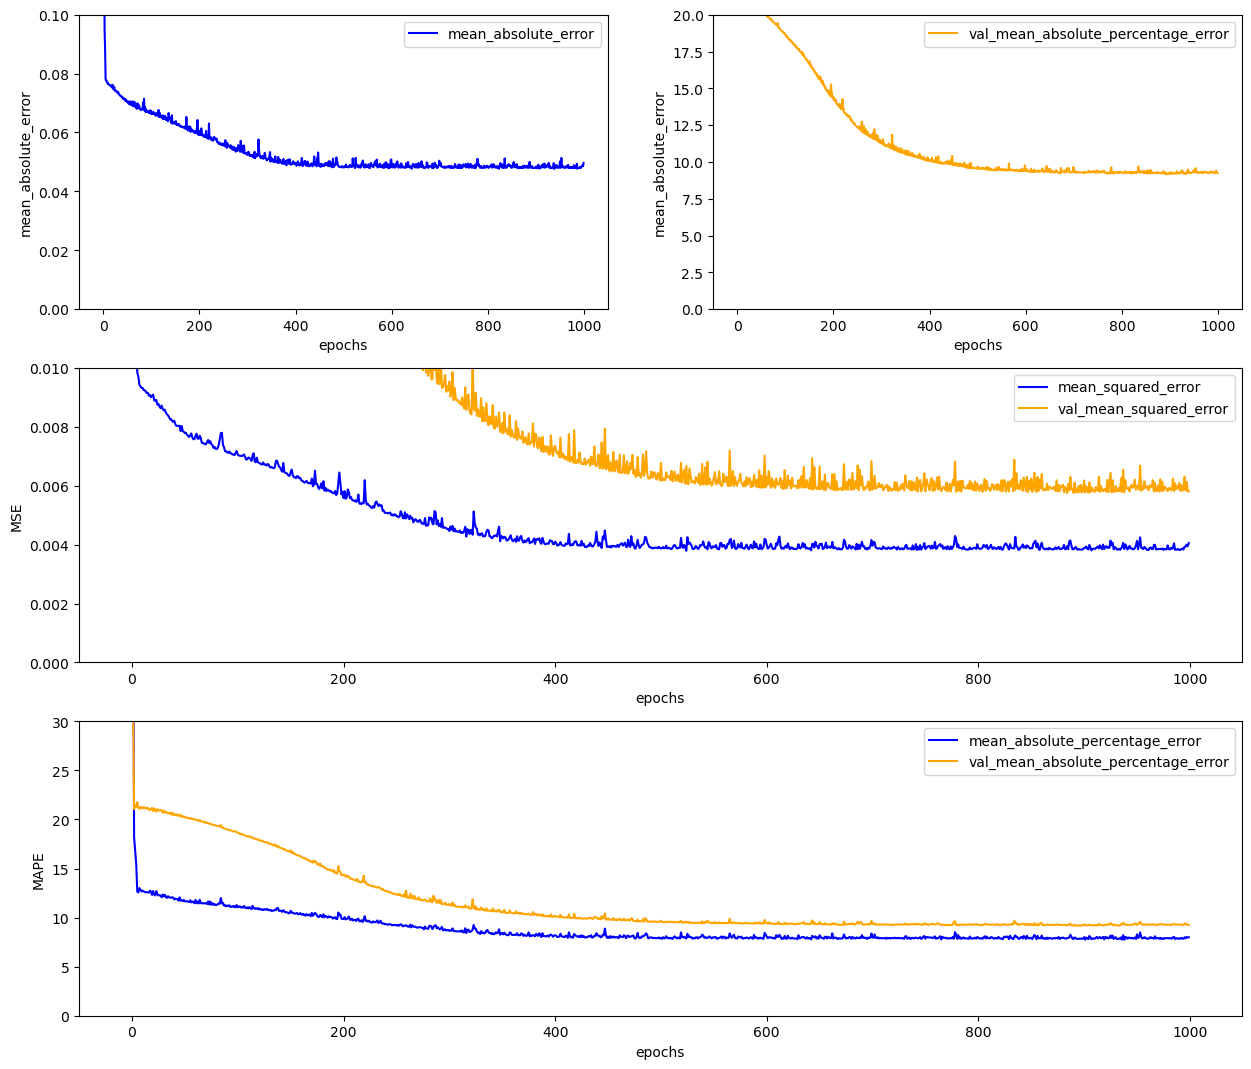

In [140]:
def theplot(history):
    fig = plt.figure(figsize=(15,13))
    ax=fig.add_subplot(3,2,1)
    ax.plot(history.history["mean_absolute_error"], label="mean_absolute_error", c="blue")
    ax.set_xlabel("epochs")
    ax.set_ylabel("mean_absolute_error")
    ax.legend(loc="upper right")
    ax.set_ylim(0,0.1)
    
    ax=fig.add_subplot(3,2,2)
    ax.plot(history.history["val_mean_absolute_percentage_error"], label="val_mean_absolute_percentage_error", c="orange")
    ax.set_xlabel("epochs")
    ax.set_ylabel("mean_absolute_error")
    ax.legend(loc="upper right")
    ax.set_ylim(0,20)
    
    ax=fig.add_subplot(3,1,2)
    ax.plot(history.history["loss"], label="mean_squared_error", c="blue")
    ax.plot(history.history["val_loss"], label="val_mean_squared_error", c="orange")
    ax.legend(loc="upper right")
    ax.set_ylim(0,0.01)
    ax.set_xlabel("epochs")
    ax.set_ylabel("MSE")
    
    ax=fig.add_subplot(3,1,3)
    ax.plot(history.history["mean_absolute_percentage_error"], label="mean_absolute_percentage_error", c="blue")
    ax.legend(loc="lower right")
    ax.set_xlabel("epochs")
    ax.set_ylabel("MAPE")
    ax.plot(history.history["val_mean_absolute_percentage_error"], label="val_mean_absolute_percentage_error", c="orange")
    ax.legend(loc="upper right")
    ax.set_xlabel("epochs")
    ax.set_ylabel("MAPE")
    ax.set_ylim(0,30)

theplot(thehistory)

In [10]:
model=keras.models.load_model("../../assets/testt30.keras",  custom_objects={"r2scoremetrics": r2scoremetrics})

Get the predicted of train and test

In [11]:
#predict
trainPredict = model.predict(trainX, batch_size=batch_size)
testPredict = model.predict(testX, batch_size=batch_size)

2/2 [==============================] - 0s 7ms/step


In [12]:
# invert scale
trainPredict = scaler.inverse_transform(trainPredict).flatten()
testPredict = scaler.inverse_transform(testPredict).flatten()


testY = scaler.inverse_transform([testY]).flatten()
trainY = scaler.inverse_transform([trainY]).flatten()

Metrics of the predicted by the model

In [29]:
# Evaluation metrics
import math
'''
print("Train")
print(f'RMSE    :   {math.sqrt(mean_squared_error(trainY,trainPredict))}')
print(f'MSE     :   {mean_squared_error(trainY,trainPredict)}')
print(f'MAE     :   {mean_absolute_error(trainY,trainPredict)}')
print(f'MAPE    :   {mean_absolute_percentage_error(trainY,trainPredict)}')
print(f'R2score :   {r2_score(trainY, trainPredict)}')


print("\nTest")
print(f'RMSE    :   {math.sqrt(mean_squared_error(testY,testPredict))}')
print(f'MSE     :   {mean_squared_error(testY,testPredict)}')
print(f'MAE     :   {mean_absolute_error(testY,testPredict)}')
print(f'MAPE    :   {mean_absolute_percentage_error(testY,testPredict)}')
print(f'R2score :   {r2_score(testY, testPredict)}')
'''

trainmetrics=pd.DataFrame([
    math.sqrt(mean_squared_error(trainY,trainPredict)),
    mean_squared_error(trainY,trainPredict),
    mean_absolute_error(trainY,trainPredict),
    mean_absolute_percentage_error(trainY,trainPredict),
    r2_score(trainY, trainPredict)
],index=["RMSE", "MSE", "MAE", "MAPE", "R2score"])

testmetrics=pd.DataFrame([
    math.sqrt(mean_squared_error(testY, testPredict)),
    mean_squared_error(testY, testPredict),
    mean_absolute_error(testY, testPredict),
    mean_absolute_percentage_error(testY, testPredict),
    r2_score(testY, testPredict)
], index=["RMSE", "MSE", "MAE", "MAPE", "R2score"])

print("Train")
print(trainmetrics)

print("\nTest")
print(testmetrics)

Train
                 0
RMSE      4.922680
MSE      24.232781
MAE       3.808556
MAPE      0.020131
R2score   0.663318

Test
                 0
RMSE      6.051815
MSE      36.624465
MAE       4.749517
MAPE      0.024459
R2score   0.782567


In [30]:
#Renormalize
testY = scaler.transform(testY.reshape(-1,1))
trainY = scaler.transform(trainY.reshape(-1,1))

Predicted vs actual plot

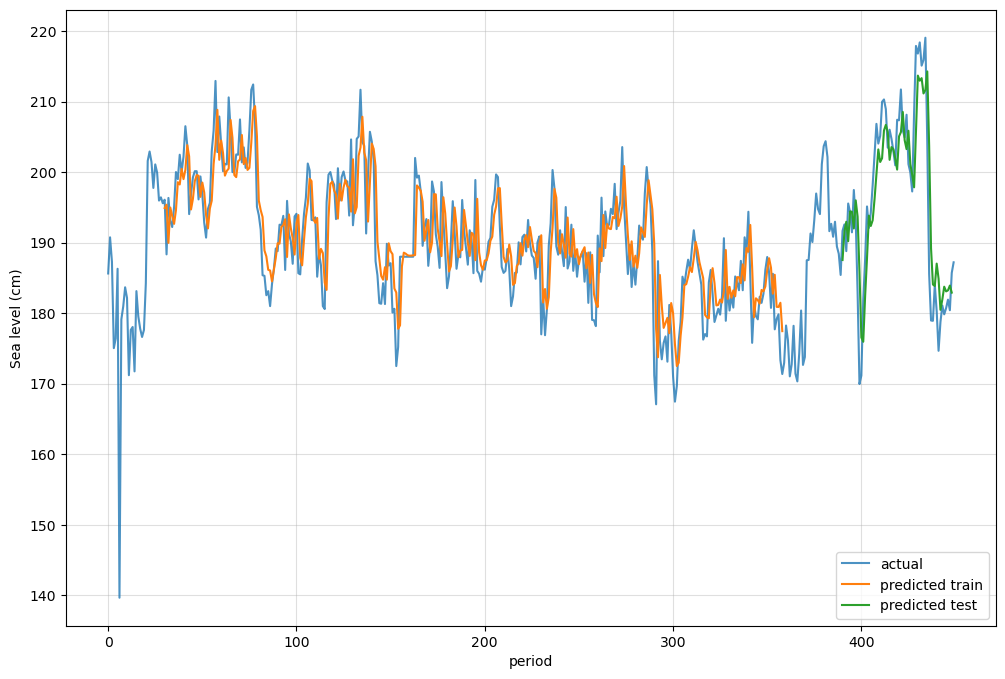

In [15]:
haha.plot_predicted(scaler.inverse_transform(df), trainPredict.reshape(-1,1), testPredict.reshape(-1,1), t)

## Getting the best model

Declare model builder

In [146]:
def model_builder(hp):
    
    #declare tuning
    firsthidden=hp.Int('1st_layer',min_value=32,max_value=512,step=32)
    secondhidden=hp.Int('2nd_layer',min_value=32,max_value=512,step=32)
    thedropout=hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)
    outputactivation=hp.Choice('output_activation',values=['relu', 'sigmoid'],default='relu')
    hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model = keras.Sequential()

    model.add(keras.layers.LSTM(firsthidden, input_shape=(t, 1), return_sequences=True))

    model.add(keras.layers.LSTM(secondhidden))
    
    model.add(keras.layers.Dropout(thedropout))
    
    model.add(keras.layers.Dense(1, activation=outputactivation))
   
    model.compile(loss='mean_squared_error', 
                  optimizer=keras.optimizers.Adam(learning_rate=hp_lr)
                  ,metrics = ['mse'])
    
    return model

Getting tuning methode

In [147]:
currenttime=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
thetuner=kt.Hyperband(model_builder, objective="mse",                       #Finding the best mse
                      max_epochs=30,
                      factor=2,
                      directory='../../assets/',  
                      project_name=currenttime)

Initiate and get best model by paramaters

In [148]:
thetuner.search(trainX, trainY, epochs=100, validation_data=(testX, testY), batch_size=batch_size)

best_hps=thetuner.get_best_hyperparameters(num_trials=1)

Trial 92 Complete [00h 00m 14s]
mse: 0.008839208632707596

Best mse So Far: 0.004701327998191118
Total elapsed time: 00h 10m 06s


Search for the best epoch of the best model

In [ ]:
#Build model with the most optimal hyperparameters and search for the most optimum epoch
model=thetuner.hypermodel.build(best_hps[0])

process=model.fit(trainX, trainY, epochs=1000, validation_data=(testX, testY), batch_size=batch_size)

val_mse_per_epoch = process.history['val_mse']
best_epoch = val_mse_per_epoch.index(max(val_mse_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [239]:
bestepoch=sorted(list(enumerate(process.history['val_loss'])), key=lambda x:x[1])[:5]
bestepoch               #best epochs range at 70-80

[(66, 0.00568300811573863),
 (79, 0.005683580879122019),
 (72, 0.005766164045780897),
 (73, 0.005908602382987738),
 (78, 0.005921036936342716)]

newly get best model and ffit with the most optimum epoch

In [ ]:
#build model with most optimum epoch
thesupasupabestmodel = thetuner.hypermodel.build(best_hps[0])

# Retrain the model
thesupasupabestmodel.fit(trainX, trainY, epochs=72, validation_data=(testX, testY), batch_size=batch_size)

In [31]:
thesupasupabestmodel=keras.models.load_model("../../assets/bestmodelt30.keras")

Getting the best model metrics

In [32]:
#predict
trainPredict = thesupasupabestmodel.predict(trainX, batch_size=batch_size)
testPredict = thesupasupabestmodel.predict(testX, batch_size=batch_size)

2/2 [==============================] - 0s 11ms/step


In [33]:
# invert scale
trainPredict = scaler.inverse_transform(trainPredict).flatten()
testPredict = scaler.inverse_transform(testPredict).flatten()


testY = scaler.inverse_transform(testY.reshape(-1,1)).flatten()
trainY = scaler.inverse_transform(trainY.reshape(-1,1)).flatten()

In [35]:
# Evaluation metrics
bestmodeltrainmetrics=pd.DataFrame([
    math.sqrt(mean_squared_error(trainY,trainPredict)),
    mean_squared_error(trainY,trainPredict),
    mean_absolute_error(trainY,trainPredict),
    mean_absolute_percentage_error(trainY,trainPredict),
    r2_score(trainY, trainPredict)
],index=["RMSE", "MSE", "MAE", "MAPE", "R2score"])

bestmodeltestmetrics=pd.DataFrame([
    math.sqrt(mean_squared_error(testY, testPredict)),
    mean_squared_error(testY, testPredict),
    mean_absolute_error(testY, testPredict),
    mean_absolute_percentage_error(testY, testPredict),
    r2_score(testY, testPredict)],index=["RMSE", "MSE", "MAE", "MAPE", "R2score"])

print("Train")
print(bestmodeltrainmetrics)

print("\nTest")
print(bestmodeltestmetrics)

Train
                 0
RMSE      4.910722
MSE      24.115186
MAE       3.816651
MAPE      0.020213
R2score   0.664952

Test
                 0
RMSE      5.856684
MSE      34.300748
MAE       4.682412
MAPE      0.023971
R2score   0.796363


In [36]:
#Renormalize
testY = scaler.transform(testY.reshape(-1,1))
trainY = scaler.transform(trainY.reshape(-1,1))

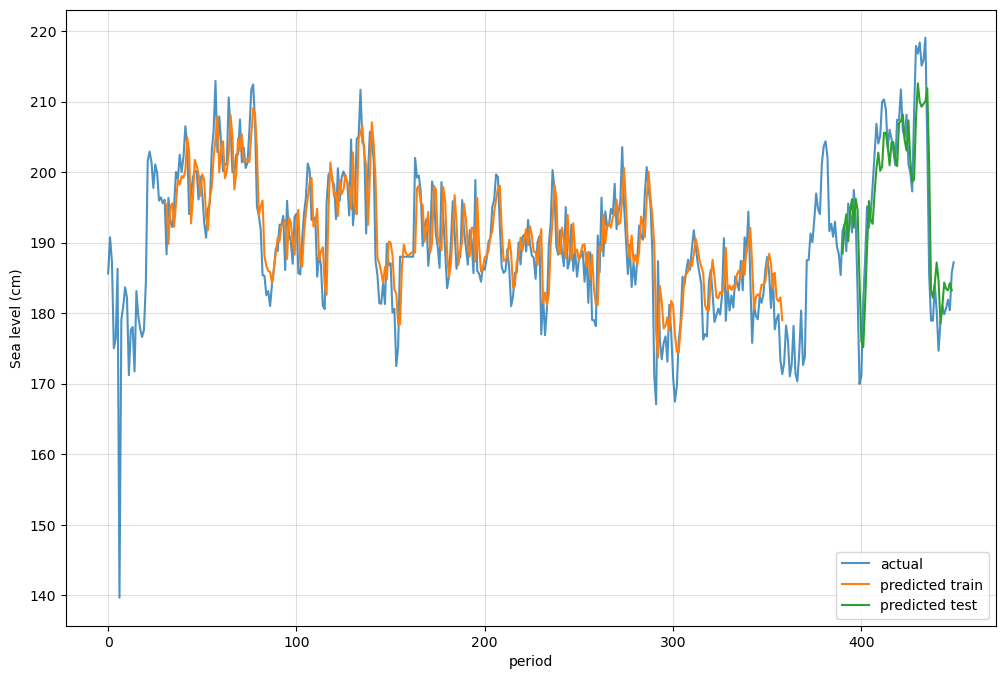

In [37]:
haha.plot_predicted(scaler.inverse_transform(df), trainPredict.reshape(-1,1), testPredict.reshape(-1,1), t)

In [276]:
thesupasupabestmodel.save("../../assets/bestmodelt30.keras")

## Comparison

In [45]:
Traincompared=pd.concat((trainmetrics, bestmodeltrainmetrics), axis=1)
Testcompared=pd.concat((testmetrics, bestmodeltestmetrics), axis=1)
Traincompared.columns=["1st model", "Best model"]
Testcompared.columns=["1st model", "Best model"]

print("Train")
print(Traincompared)

print("\nTest")
print(Testcompared)

Train
         1st model  Best model
RMSE      4.922680    4.910722
MSE      24.232781   24.115186
MAE       3.808556    3.816651
MAPE      0.020131    0.020213
R2score   0.663318    0.664952

Test
         1st model  Best model
RMSE      6.051815    5.856684
MSE      36.624465   34.300748
MAE       4.749517    4.682412
MAPE      0.024459    0.023971
R2score   0.782567    0.796363


## Forecasting

Get the next 60 days

In [23]:
def forecast(predictedday, model, testdata, t):
    forecasted=[]
    theinput=testdata[-t:]

    firstinput = theinput.reshape((1, t,1))
    temppredicted = model.predict(firstinput, verbose=0)
    theinput=np.concatenate((theinput, temppredicted), axis=0)
    forecasted.append(scaler.inverse_transform(temppredicted.reshape(1,-1))[0])
    
    for i in range(1,predictedday):
        theinput=theinput[1:].flatten().reshape(1,t,1)
        temppredicted=model.predict(theinput, verbose=0)
        theinput=np.concatenate((theinput.reshape(-1,1), temppredicted), axis=0)
        forecasted.append(scaler.inverse_transform(temppredicted.reshape(1,-1))[0])
        
    return np.array(forecasted)

iwannaforecast=60
z=forecast(predictedday=iwannaforecast, model=thesupasupabestmodel, testdata=test, t=t)

Plot Latest data n=15 vs next 60 forecasted

Text(0.5, 0, 'Period')

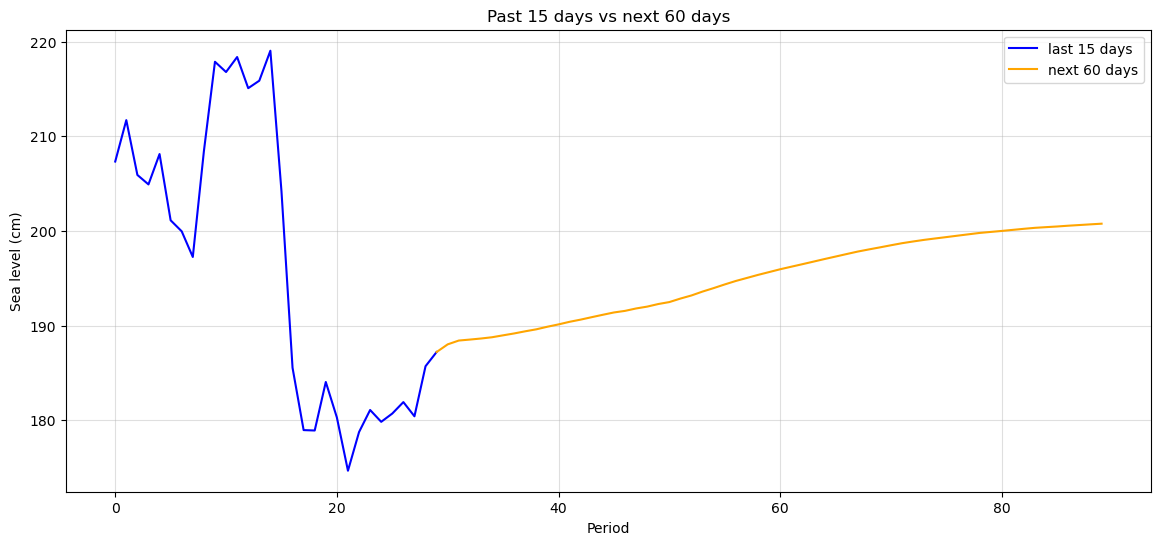

In [24]:
temp=np.array([None for i in range(t+iwannaforecast)])
temp[t-1]=scaler.inverse_transform(test)[len(test)-1][0]
temp[t:]=z.flatten()

fig, ax = plt.subplots(1,1, figsize=(14,6))
ax.plot(scaler.inverse_transform(test[-t:]), c="blue", label="last 15 days")
ax.plot(temp, c="orange", label="next 60 days")
ax.grid(alpha=0.4)
ax.set_title("Past 15 days vs next 60 days")
ax.legend(loc="upper right")
ax.set_ylabel("Sea level (cm)")
ax.set_xlabel("Period")

Plot the entire dataset with the forecasted data (n=60)

Text(0.5, 0, 'Period')

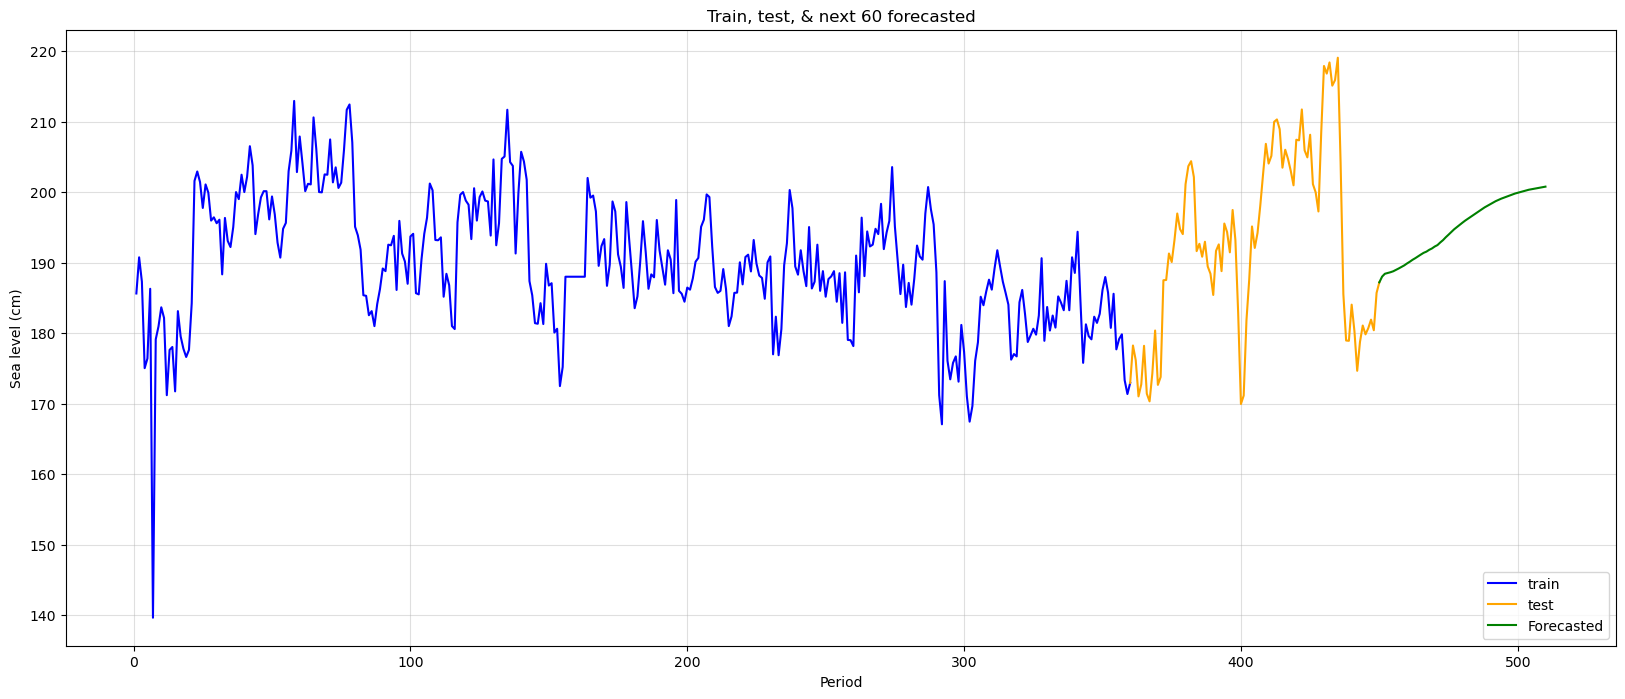

In [54]:
fig, ax = plt.subplots(1,1, figsize=(20,8))
temp=np.array(list(map(list, zip(train.flatten(), range(1,len(train)+1)))))
ax.plot(temp[:,1], scaler.inverse_transform(temp[:,0].reshape(-1, 1)), c="blue", label="train")

temp=np.array(list(map(list, zip(test.flatten(), range(len(train)+1,len(train)+len(test)+1)))))
temp=np.concatenate(([[train.flatten()[-1],len(train)]], temp),axis=0)

ax.plot(temp[:,1], scaler.inverse_transform(temp[:,0].reshape(-1, 1)), c="orange", label="test")

temp=np.array([None for i in range(len(df)+iwannaforecast+1)])
temp[len(df):]=scaler.inverse_transform(test)[len(test)-1][0]
temp[len(df)+1:]=z.flatten()
ax.plot(temp, c="green", label="Forecasted")

ax.legend(loc="lower right")
ax.set_title("Train, test, & next 60 forecasted")
ax.grid(alpha=0.4)
ax.set_ylabel("Sea level (cm)")
ax.set_xlabel("Period")